In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### Accessing Datasets / Data Exploration

In [ ]:
%%bigquery df_fire
SELECT
*
FROM `data-401-326622.final_project.fires`

Downloading: 100%|██████████| 20772/20772 [00:15<00:00, 1350.82rows/s]


In [ ]:
df_fire.shape

(20772, 19)

In [ ]:
%%bigquery df_climate
SELECT * FROM `data-401-326622.final_project.terraclimate_with_fire_distance`

Downloading: 100%|██████████| 7338672/7338672 [00:05<00:00, 1234994.05rows/s]


In [ ]:
df_climate.shape

(7338672, 19)

In [ ]:
#creating new indicator variable based on fire_dist
def fire_function(row):
    if row["fire_dist"] >= 5000 or np.isnan(row["fire_dist"]):
        val = 0
    else:
        val = 1
    return val

df_climate["fire"] = df_climate.apply(fire_function, axis=1)

df_climate = df_climate.drop(columns=["fire_dist"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


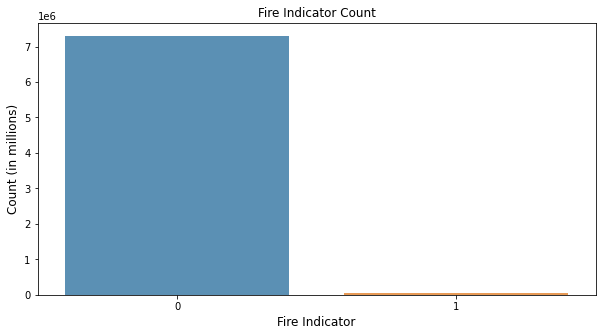

In [ ]:
#Data Visualization 1
fire_count = df_climate["fire"].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(fire_count.index, fire_count.values, alpha=0.8)
plt.title('Fire Indicator Count')
plt.ylabel('Count (in millions)', fontsize=12)
plt.xlabel('Fire Indicator', fontsize=12)
plt.show()

In [ ]:
df_climate["fire"].value_counts()

0    7299294
1      39378
Name: fire, dtype: int64

In [ ]:
#Data Visualization 2

In [ ]:
%%bigquery avg_fire_month
SELECT
    AVG(CAST(fire_dist as FLOAT64)) as avg_fire_dist,
    month
FROM `data-401-326622.final_project.terraclimate_with_fire_distance`
GROUP BY month

Downloading: 100%|██████████| 12/12 [00:01<00:00,  9.53rows/s]


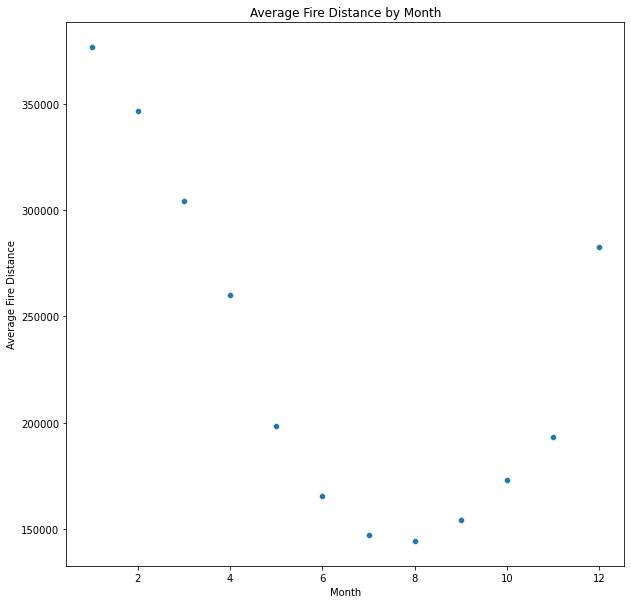

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='month',y='avg_fire_dist',data=avg_fire_month,ax=ax,legend=False)
ax.set_xlabel('Month')
ax.set_ylabel('Average Fire Distance')
ax.set_title('Average Fire Distance by Month')
fig.show()

In [ ]:
del avg_fire_month

In [ ]:
#!wget https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/b0007416-a325-4777-9295-368ea6b710e6/download/ca-county-boundaries.zip -O cali_data.zip
#!unzip cali_data.zip
#!rm cali_data.zip

Text(493.45748678457437, 0.5, 'Latitude [deg]')

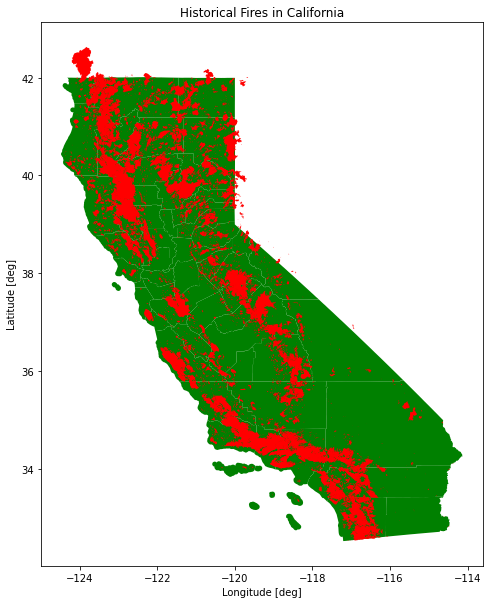

In [ ]:
#Data Visualization 3
df_boundaries = gpd.read_file("CA_Counties_TIGER2016.shx")
df_boundaries = df_boundaries.to_crs(epsg = 4326)
df_fire = gpd.GeoDataFrame(df_fire,geometry=gpd.GeoSeries.from_wkt(df_fire.geom),crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(20, 10))
ax = df_boundaries.plot(ax=ax, color = "green")
df_fire.plot(ax=ax, color = "red")
ax.set_title("Historical Fires in California")
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

In [ ]:
del df_boundaries
del df_fire

In [ ]:
%%bigquery df_boundaries
SELECT
    county_name,
    county_geom
FROM `bigquery-public-data.geo_us_boundaries.counties`
WHERE state_fips_code = "06"

Downloading: 100%|██████████| 58/58 [00:02<00:00, 28.22rows/s]


In [ ]:
df_boundaries.head()

,county_name,county_geom
0,Alpine,"POLYGON((-120.073331 38.70109, -120.073324 38...."
1,Mariposa,"POLYGON((-120.321526 37.5244, -120.321485 37.5..."
2,Trinity,"POLYGON((-123.543956 40.732938, -123.544172 40..."
3,Amador,"POLYGON((-121.027291 38.481365, -121.027291 38..."
4,Inyo,"POLYGON((-118.337579 36.654801, -118.336827 36..."


### Data Preparation

In [ ]:
df_climate = gpd.GeoDataFrame(df_climate,geometry=gpd.GeoSeries.from_xy(df_climate.lon,df_climate.lat),crs='EPSG:4326')
df_boundaries = gpd.GeoDataFrame(df_boundaries,geometry=gpd.GeoSeries.from_wkt(df_boundaries.county_geom),crs='EPSG:4326')

In [ ]:
df_final = gpd.sjoin(df_climate, df_boundaries)

del df_boundaries

df_final = df_final.drop(columns=['lat', 'lon', 'geometry', 'index_right', 'county_geom'])

In [ ]:
#balancing data
df_final["fire"].value_counts()

0    3234741
1      38991
Name: fire, dtype: int64

In [ ]:
3234741 / 38991

82.96122182042009

In [ ]:
def weight_function(row):
    if row["fire"] == 0:
        val = 1
    else:
        val = 83
    return val

df_final["Weights"] = df_final.apply(weight_function, axis=1)

df_final2 = df_final.sample(n=len(df_final), weights='Weights', random_state=12, replace = True)

df_final2 = df_final2.drop(columns = "Weights")

df_final2["fire"].value_counts()

0    1637315
1    1636417
Name: fire, dtype: int64

In [ ]:
del df_final

In [ ]:
y = df_final2["fire"]

df_final2 = df_final2.drop(columns = ["fire"])

In [ ]:
categorical_features = ["county_name", "month", "year"]
numeric_features = [col for col in df_final2.columns if col not in categorical_features]

In [ ]:
#One Hot Encoding
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

#Use Onehot encoding for all the categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[("numeric", numeric_transformer, numeric_features),
                                               ("categorical", categorical_transformer, categorical_features)])

In [ ]:
transformed = preprocessor.fit_transform(df_final2)

In [ ]:
new_categorical = preprocessor.transformers_[1][1].get_feature_names_out()

#Create a new dataframe with the all the transformed column names
X = pd.DataFrame.sparse.from_spmatrix(transformed, columns=numeric_features + list(new_categorical))


X.head()

,aet,def,pet,ppt,q,soil,srad,swe,tmax,tmin,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.073898,-0.120050,-0.155823,0.112699,0.1127,-0.013479,1.635816,0.1127,-0.142133,-0.024519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.123548,-0.009865,0.001672,0.112700,0.1127,-0.017177,0.708299,0.1127,-0.107161,-0.053452,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.046496,0.191275,0.128809,0.112699,0.1127,0.013997,-0.551377,0.1127,0.128652,0.293483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.069557,0.198812,0.158388,0.112699,0.1127,-0.000533,-0.118865,0.1127,0.115662,0.175120,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.138469,-0.137202,-0.111195,0.112700,0.1127,0.033019,1.416374,0.1127,-0.102165,-0.032410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Data Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X, y)
y_pred = clf.predict(X_test)

In [ ]:
accuracy_lr = metrics.accuracy_score(y_test, y_pred)
f1_lr = metrics.f1_score(y_test, y_pred)

In [ ]:
#Logistic Regression
clf.intercept_, clf.coef_

(array([-0.73477404]),
 array([[ 3.34524561e+00,  4.23804688e+00, -1.71518474e+00,
          9.66954040e+00,  9.66051089e+00, -4.38971088e-01,
          3.11044121e-01,  9.65911168e+00,  4.80191338e+00,
         -4.23230307e+00, -4.74186017e+00, -2.51953217e+00,
         -2.29857409e+01, -4.50969455e+00, -3.05209931e-01,
         -1.09017351e+00, -1.74597472e-01,  1.01709917e+00,
          4.41715313e-01, -3.36534531e-01, -6.10694928e-01,
          5.04477552e-01,  2.48580703e-01,  2.30143710e-01,
         -1.33355561e-01,  9.38674406e-02, -2.22708977e+00,
         -2.26788760e+00,  2.21833744e-01, -1.27756984e+00,
          6.28661808e-01, -8.43565090e-01,  1.26388360e+00,
          1.50155064e-01,  5.78565707e-01,  1.26918135e+00,
         -3.60165150e-02, -1.12130705e+00, -6.41027766e-01,
         -1.11830529e+00,  2.56439096e-01,  9.83146821e-01,
          7.17194149e-02,  1.38178498e+00,  9.88083316e-01,
          1.87709442e-01,  1.65664661e-03, -7.17573972e-01,
         -7.20456

In [ ]:
table = pd.DataFrame({'variable': X.columns, 'coefficient': clf.coef_.flatten()})
table.reindex(table.coefficient.abs().sort_values(ascending=False).index).head(10)

,variable,coefficient
12,vpd,-22.985741
3,ppt,9.669540
4,q,9.660511
7,swe,9.659112
8,tmax,4.801913
10,vap,-4.741860
13,PDSI,-4.509695
1,def,4.238047
9,tmin,-4.232303
0,aet,3.345246


In [ ]:
rfc = RandomForestClassifier(n_estimators = 10) 
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

In [ ]:
accuracy_rfc = metrics.accuracy_score(y_test, y_pred)
f1_rfc = metrics.f1_score(y_test, y_pred)

In [ ]:
#Random Forest

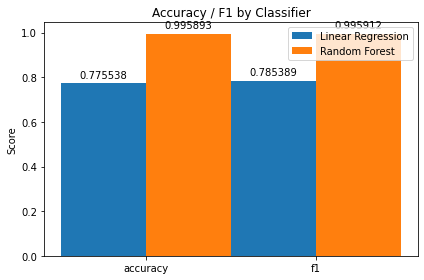

In [ ]:
labels = ['accuracy', 'f1']

lr_list = [accuracy_lr, f1_lr]
rfc_list = [accuracy_rfc, f1_rfc]

x = np.arange(len(labels))
width = 0.50

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lr_list, width, label='Linear Regression')
rects2 = ax.bar(x + width/2, rfc_list, width, label='Random Forest')

ax.set_ylabel('Score')
ax.set_title('Accuracy / F1 by Classifier')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()